# April 2, 2025: generalizability of comms. across animals
and consistent set of rois per comm. 

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random
from sklearn.utils import resample

# import arviz as az

import ants
from nipype.interfaces import afni
from nilearn.plotting import plot_stat_map

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial


# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
roi_table = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')
roi_table

,old_roi,name,roi
0,1,"R-Frontal pole, cerebral cortex (FRP,184)",1
1,2,"R-Primary motor area (MOp,985)",2
2,3,"R-Secondary motor area (MOs,993)",3
3,4,"R-Primary somatosensory area, nose (SSp-n,353)",4
4,5,"R-Primary somatosensory area, barrel field (SS...",5
...,...,...,...
167,168,"L-Medulla, sensory related (MY-sen,472)",168
168,169,"L-Medulla, motor related (MY-mot,456)",169
169,170,"L-Medulla, behavioral state related (MY-sat,465)",170
170,171,"L-Cerebellar cortex (CBX,614)",171


In [6]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [7]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 172 vertices and 2942 edges, 1 internal edge property, at 0x7f3e101abe80>

In [8]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    num_rois = num_rois
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

In [9]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9943502824858758, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9082639088384565, 0.005617798206134892, 0....","[[0.8850912125784436, 0.09756830776993501, 0.0...","[[0.9881457547053836, 0.011854245294616511], [...","[[0.9952583018821535, 0.004741698117846605], [...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[1.0], [1.0], [1.0000000000000002], [1.0], [0...",0.177295,0
1,SLC01,sbm-nd-h,"[[0.9924242424242424, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9305555555555556, 0.0, 0.00751836547291092...","[[0.8583704854173055, 0.11905640763280642, 0.0...","[[0.9686317578785476, 0.03136824212145242], [0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.132086,1
2,SLC01,sbm-nd-h,"[[0.9672131147540983, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9002956194571352, 0.0, 0.00792797635044343...","[[0.8373335842458809, 0.11451218593710696, 0.0...","[[0.9879460856908309, 0.012053914309169156], [...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...",0.122464,2
3,SLC01,sbm-nd-h,"[[0.989247311827957, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.9813851312290439, 0.0, 0.00011562030292519...","[[0.9137888107775382, 0.06490505861861601, 0.0...","[[0.9885271006993847, 0.011472899300615397], [...","[[0.997705420139877, 0.0022945798601230792], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.093199,3
4,SLC01,sbm-nd-h,"[[0.44565217391304346, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.9117334697438667, 0.028759166164648204, 0....","[[0.9033271327908874, 0.095322184980498, 0.000...","[[0.9909216966685239, 0.009078303331476], [0.9...","[[0.995460848334262, 0.004539151665738], [0.99...","[[0.995460848334262, 0.004539151665738], [0.99...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...",0.091858,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.02105398883751773, 0.00040523863029342963,...","[[0.9629751425533718, 0.0367510004382298, 0.00...","[[0.9914532557120393, 0.008546744287960418], [...","[[0.9982906511424077, 0.0017093488575920836], ...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...",0.233420,1
81,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9869606077218264,...","[[0.9629514024881322, 0.037048597511867884, 0....","[[0.9919459570626374, 0.008054042937362584], [...","[[0.9991945957062638, 0.0008054042937362584], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.226136,2
82,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.014634146341463415, 0.0, 0.0, 0.0, 0.0, 0....","[[0.9943370542744164, 0.0054487874864401434, 0...","[[0.9995046556830509, 0.000495344316949104], [...","[[0.9997523278415255, 0.000247672158474552], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",

In [10]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0_aligned',
 'pi_1_aligned',
 'pi_2_aligned',
 'pi_3_aligned',
 'pi_4_aligned',
 'pi_5_aligned',
 'pi_6_aligned',
 'pi_7_aligned',
 'pi_8_aligned']

In [11]:
# SOFT MARGINALS
soft_marginals_df = []
for sub, group in marginals_df.groupby('sub'):
    omegas = group['omega'].to_list()
    dct = {'sub': [sub], 'sbm': [SBM]}
    for col in cols:
        M = get_membership_matrix(args.num_rois, group, col=col)
        SCs = np.average(M, axis=1, weights=omegas) # soft-comms.
        SCs = np.round(SCs, decimals=3)
        dct[col] = [SCs]
    soft_marginals_df += [pd.DataFrame(dct)]
soft_marginals_df = pd.concat(soft_marginals_df).reset_index(drop=True)
soft_marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,SLC01,sbm-nd-h,"[[0.835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.923, 0.008, 0.005, 0.005, 0.0, 0.005, 0.00...","[[0.891, 0.088, 0.021, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.986, 0.014], [0.982, 0.018], [0.983, 0.017...","[[0.998, 0.002], [0.997, 0.003], [0.997, 0.003...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
1,SLC03,sbm-nd-h,"[[0.996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, ...","[[0.677, 0.0, 0.0, 0.001, 0.004, 0.001, 0.317,...","[[0.615, 0.322, 0.05, 0.0, 0.004, 0.0, 0.009, ...","[[0.943, 0.056, 0.0, 0.0, 0.001, 0.0], [0.955,...","[[0.992, 0.008], [0.994, 0.006], [0.993, 0.007...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[0.999, 0.001], [1.0, 0.0], [0.999, 0.001], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
2,SLC04,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.058, 0.222, 0.001, 0.207, 0.0, 0.501, 0.00...","[[0.84, 0.153, 0.005, 0.003, 0.0, 0.0, 0.0], [...","[[0.979, 0.021], [0.977, 0.023], [0.978, 0.022...","[[0.997, 0.003], [0.997, 0.003], [0.997, 0.003...","[[0.999, 0.001], [0.999, 0.001], [0.999, 0.001...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
3,SLC05,sbm-nd-h,"[[0.0, 0.0, 0.989, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.029, 0.087, 0.0, 0.882, 0.0, 0.0, 0.001, 0...","[[0.878, 0.115, 0.006, 0.0, 0.0, 0.0, 0.0], [0...","[[0.98, 0.02, 0.0, 0.0, 0.0], [0.98, 0.02, 0.0...","[[0.997, 0.003], [0.997, 0.003], [0.997, 0.003...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
4,SLC06,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.002, 0.001, 0.007, 0.0, 0.0, 0.006, 0.0, 0...","[[0.909, 0.068, 0.015, 0.0, 0.0, 0.0, 0.008], ...","[[0.985, 0.015, 0.0, 0.0, 0.0, 0.0], [0.969, 0...","[[0.998, 0.002], [0.996, 0.004], [0.997, 0.003...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
5,SLC07,sbm-nd-h,"[[0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.014, 0.017, 0.0, 0.968, 0.0, 0.0, 0.0, 0.0...","[[0.85, 0.149, 0.001, 0.0, 0.0, 0.0, 0.0], [0....","[[0.98, 0.02, 0.0, 0.0, 0.0, 0.0], [0.981, 0.0...","[[0.995, 0.005], [0.995, 0.005], [0.995, 0.005...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
6,SLC08,sbm-nd-h,"[[0.047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.06, 0.014, 0.0, 0.918, 0.0, 0.0, 0.005, 0....","[[0.882, 0.091, 0.026, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.983, 0.017, 0.0, 0.0, 0.0], [0.982, 0.018,...","[[0.998, 0.002], [0.998, 0.002], [0.998, 0.002...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,SLC09,sbm-nd-h,"[[0.008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.052, 0.0, 0.002, 0.0, 0.024, 0.059, 0.036,...","[[0.926, 0.065, 0.005, 0.0, 0.0, 0.0, 0.003, 0...","[[0.99, 0.01, 0.0, 0.0, 0.0], [0.972, 0.026, 0...","[[0.999, 0.001], [0.998, 0.002], [0.998, 0.002...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1

In [12]:
# core-score per roi

In [13]:
def bootstrap(matrices, statistic=np.median, n_bootstrap=1000):
    stacked = np.stack(matrices)
    bootstrap_means = np.stack([
        statistic(resample(stacked), axis=0)
        for _ in range(n_bootstrap)
    ])
    return (
        statistic(bootstrap_means, axis=0), # mean := probability of var type per roi
        np.percentile(bootstrap_means, [2.5, 97.5], axis=0) # CI
    )

In [14]:
def get_consensus_score(M, epsilon=1e-6):
    median, ci = bootstrap(
        [M[:, i, :] for i in range(M.shape[1])],
    )
    delta = ci[1] - ci[0]
    
    # median = np.median(M, axis=1)
    # mad = np.median(np.abs(M - median[:, None, :]), axis=1)
    consensus_scores = median * np.exp(-delta / (median + epsilon))
    return median, delta, consensus_scores

In [15]:
consensus_scores_df = []
for col in cols:
    M = get_membership_matrix(args.num_rois, soft_marginals_df, col=col)
    pi_median, pi_delta, CS = get_consensus_score(M)
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        median=[pi_median],
        delta=[pi_delta],
        consensus_score=[CS],
    ))
    consensus_scores_df += [row]
consensus_scores_df = pd.concat(consensus_scores_df).reset_index(drop=True)

In [16]:
consensus_scores_df

,sbm,col,median,delta,consensus_score
0,sbm-nd-h,pi_0_aligned,"[[0.008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[0.996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[6.921255046519797e-57, 0.0, 0.0, 0.0, 0.0, 0..."
1,sbm-nd-h,pi_1_aligned,"[[0.052, 0.008, 0.0, 0.005, 0.0, 0.005, 0.001,...","[[0.663, 0.087, 0.005, 0.918, 0.004, 0.501, 0....","[[1.5095766966023435e-07, 1.5160998038924502e-..."
2,sbm-nd-h,pi_2_aligned,"[[0.882, 0.091, 0.006, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.05942499999999962, 0.08107499999999998, 0....","[[0.824532739029883, 0.03733514958192332, 9.30..."
3,sbm-nd-h,pi_3_aligned,"[[0.983, 0.017, 0.0, 0.0, 0.0, 0.0], [0.98, 0....","[[0.01100000000000001, 0.011000000000000001, 0...","[[0.9720613284209338, 0.008901257692975555, 0...."
4,sbm-nd-h,pi_4_aligned,"[[0.998, 0.002], [0.997, 0.003], [0.997, 0.003...","[[0.0040000000000000036, 0.004], [0.0030000000...","[[0.994008009325305, 0.0002709412370171541], [..."
5,sbm-nd-h,pi_5_aligned,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[0.0010000000000000009, 0.001], [0.0010000000...","[[0.9990005008323746, 0.0], [0.999000500832374..."
6,sbm-nd-h,pi_6_aligned,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."
7,sbm-nd-h,pi_7_aligned,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...","[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."
8,sbm-nd-h,pi_8_aligned,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."


In [17]:
# rois per comm

In [18]:
relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]

In [45]:
def collect_roi_names_per_comm(roi_table, rois):
    df = pd.DataFrame()
    df[['hemi', 'label_id']] = roi_table.loc[rois]['name'].str.extract(r'^(L|R)-.*\(([^)]+)\)')
    df[['acronym', 'id']] = df['label_id'].str.extract(r'([^,]+),(\d+)')
    df['short_label'] = df['hemi'] + '-' + df['acronym'] + '(' + df['id'] + ')'
    return df['short_label'].to_list()

In [47]:
col = cols[0]
CS = consensus_scores_df[consensus_scores_df['col'] == col]['consensus_score'].to_list()[0]

roi_names_df = []

for idx_comm in range(CS.shape[1]):
    if not idx_comm in relevant_comms: continue
    comm = CS[:, idx_comm]
    rois = np.round(comm[np.argsort(comm)], decimals=3) > 0.1
    rois = np.argsort(comm)[rois][::-1]
    roi_names = collect_roi_names_per_comm(roi_table, rois)
    roi_names_df += [dict(
        comm=idx_comm,
        roi_names=roi_names,
    )]
    # print(idx_comm)
    # display(roi_table.loc[rois])
roi_names_df = pd.DataFrame(roi_names_df)
roi_names_df

,comm,roi_names
0,0,"[L-ILA(130), R-ILA(44), L-ORBm(817), L-PL(1058..."
1,1,"[L-SSp-m(431), L-MOp(1071), R-SSp-m(345), L-SS..."
2,3,"[R-RSPagl(894), R-VISam(394), R-SSp-tr(361), R..."
3,4,"[R-VISp(385), R-VISli(312782574), R-VISal(402)..."
4,5,"[R-ACAd(39), L-ACAd(125), R-ACAv(48), L-ACAv(1..."
5,6,"[L-LSX(361), R-LSX(275)]"
6,8,"[R-STRv(493), R-PIR(961)]"
7,10,"[R-PERI(922), R-ECT(895), R-HIP(1080), R-RHP(8..."
8,11,"[L-MOB(593), R-MOB(507), R-AOB(151), L-AOB(237..."
9,12,"[R-COA(631), R-sAMY(278), R-MEZ(467), R-LZ(290..."


In [48]:
folder = (
    f'{ESTIM_path}/group/community-consensus'
    f'/{SBM}'
)
os.system(f'mkdir -p {folder}')
roi_names_df.to_csv(f'{folder}/desc-consistent-core-rois.csv')

In [49]:
latex_table = df.to_latex(
    index=False,
    escape=False,  # so that underscores, parentheses etc. are preserved
    column_format='rl',  # right-align community ID, left-align names
    caption="Consistent core ROIs for each community.",
    label="tab:core_rois"
)
latex_table

'\\begin{table}\n\\caption{Consistent core ROIs for each community.}\n\\label{tab:core_rois}\n\\begin{tabular}{rl}\n\\toprule\nhemi & label_id & acronym & id & short_label \\\\\n\\midrule\nR & STRd,485 & STRd & 485 & R-STRd(485) \\\\\nR & CLA,583 & CLA & 583 & R-CLA(583) \\\\\nR & AId,104 & AId & 104 & R-AId(104) \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [20]:
# central tendency (median) of marginal memberships across animals

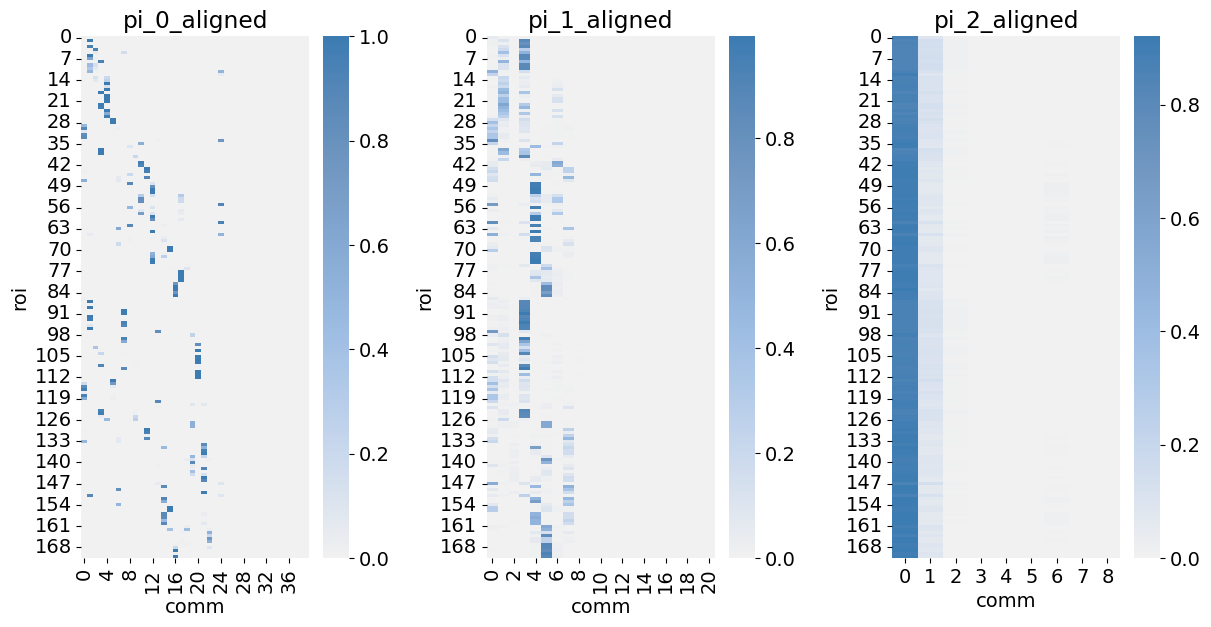

In [21]:
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in consensus_scores_df.iterrows():
    if idx > 2: continue
    ax = axs[idx]
    col = row['col']
    M = row['median']
    sns.heatmap(M, ax=ax, cmap=cc.cm.CET_L12)
    ax.set(title=f'{col}', xlabel='comm', ylabel='roi')

In [22]:
# community concentrations, reliable across animals

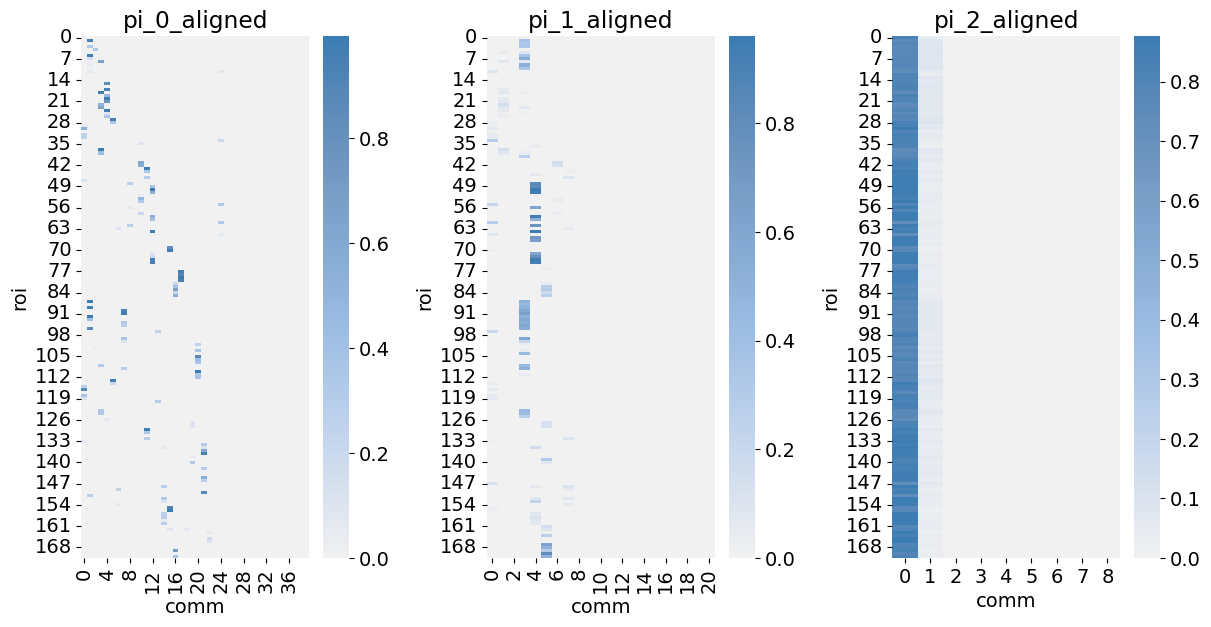

In [23]:
nrows = 1
ncols = 3 #len(consensus_scores_df)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in consensus_scores_df.iterrows():
    if idx > 2: continue
    ax = axs[idx]
    col = row['col']
    CS = row['consensus_score']
    sns.heatmap(CS, ax=ax, cmap=cc.cm.CET_L12)
    ax.set(title=f'{col}', xlabel='comm', ylabel='roi')

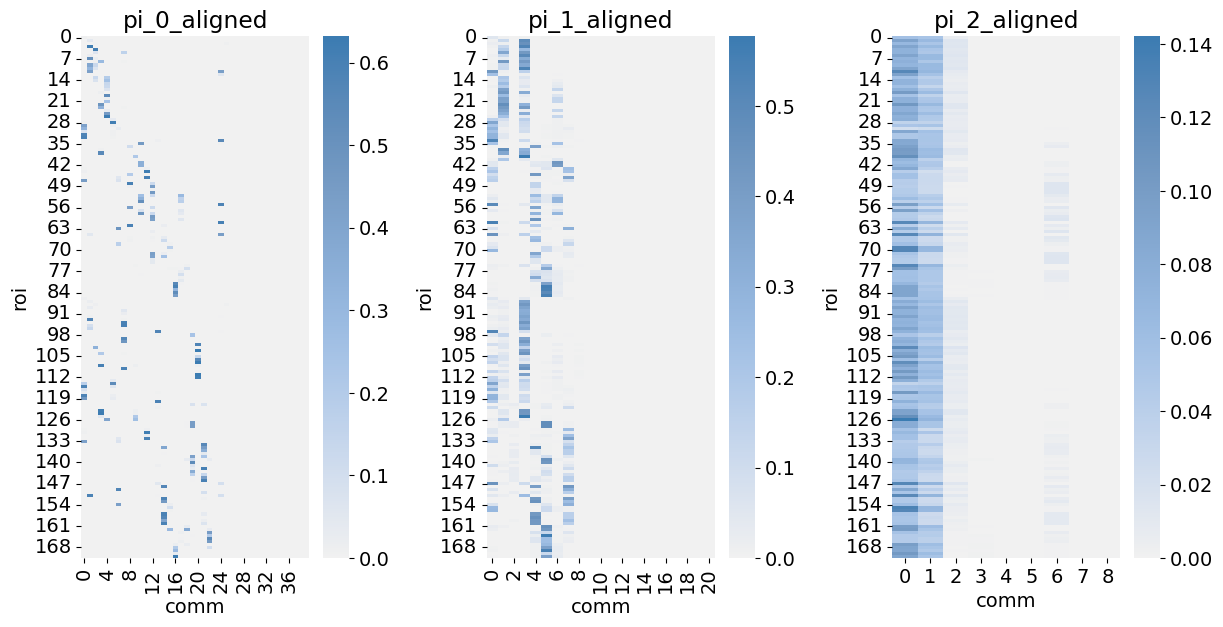

In [24]:
nrows = 1
ncols = 3 #len(consensus_scores_df)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in consensus_scores_df.iterrows():
    if idx > 2: continue
    ax = axs[idx]
    col = row['col']
    M = row['median']
    CS = row['consensus_score']
    sns.heatmap(M-CS, ax=ax, cmap=cc.cm.CET_L12)
    ax.set(title=f'{col}', xlabel='comm', ylabel='roi')

In [25]:
# save CS in nii files

In [26]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')

try:
    roi_labels = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')['roi'].to_list()
except:
    roi_labels = np.arange(1, args.num_rois+1)

In [27]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

def marginal_to_nifti(args, parcels_img, X, mode_id, folder, level=-1):
    parcels_vol = parcels_img.numpy()
    parcels_vol = np.round(parcels_vol, decimals=0)

    os.system(f'mkdir -p {folder}')
    args.num_rois, args.num_comms = X.shape

    in_files = []
    for idx_comm in range(args.num_comms):
        x = X[:, idx_comm]
        x_img = np.zeros_like(parcels_vol)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels_vol == roi) * (x[idx])
        
        file = f'{folder}/mode-{mode_id}_comm-{idx_comm}.nii.gz'
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)

    if level == -1:
        out_file = f'{folder}/mode-{mode_id:02d}.nii.gz'
    else:
        out_file = f'{folder}/mode-{mode_id:02d}_level-{level}.nii.gz'
    concatenate(in_files, out_file)
    return None

In [28]:
parcels_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (57, 40, 66)
	 Spacing    : (0.2, 0.2, 0.2)
	 Origin     : (5.78, 7.83, -6.93)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [29]:
for idx, row in consensus_scores_df.iterrows():
    col = row['col']
    CS = row['consensus_score']
    
    level = col.split('_')[1]
    if level == 'aligned': level = -1

    print(f'level {level}')
    folder = (
        f'{ESTIM_path}/group/community-consensus'
        f'/{SBM}/visuals/res-{args.resolution}/nii'
    )
    os.system(f'mkdir -p {folder}')
    # marginal_to_nifti(args, parcels_img, CS, 0, folder, level)
    
    # break

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8


In [30]:
# visualize via nilearn

In [31]:
template_file = f'{PARCELS_path}/source-{args.source}_space-{args.space}_res-{args.resolution}_desc-template.nii.gz'
template_img = ants.image_read(template_file)
template_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (57, 40, 66)
	 Spacing    : (0.2, 0.2, 0.2)
	 Origin     : (5.78, 7.83, -6.93)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [32]:
def plot_comms_nilearn(comms_img_file):
    fs = comms_img_file.split('/')
    id = fs[-1].split('.')[0]
    out_file = '/'.join(fs[:-1] + [f'{id}.pdf'])

    comms_img = ants.image_read(comms_img_file)
    comms_vol = comms_img.numpy()
    num_comms = min(23, comms_vol.shape[-1])

    ncols = 5
    nrows = np.ceil(num_comms / ncols).astype(int)
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    fig.tight_layout(h_pad=0, w_pad=0)

    for idx_comm in tqdm(range(num_comms)):
        r, c = idx_comm // ncols, idx_comm % ncols
        ax = axs[r, c] if nrows > 1 else axs[c]
        
        comm_vol = comms_vol[:, :, :, idx_comm]
        template_img.new_image_like(comm_vol).to_file(f'comm_img.nii.gz')

        plot_stat_map(
            stat_map_img=f'comm_img.nii.gz',
            bg_img=template_file,
            threshold=0.2,
            black_bg=False,
            dim=1.0,
            vmin=0.0, 
            vmax=1.0,
            cmap=cc.cm.CET_L12,
            display_mode='ortho',
            axes=ax,
            title=f'comm: {idx_comm:02d}',
        )

        # break
    for c_ in range(c+1, ncols):
        ax = axs[r, c_] if nrows > 1 else axs[c_]
        fig.delaxes(ax)

    fig.savefig(f'{out_file}', transparent=True, bbox_inches='tight')
    return fig

In [33]:
folder = (
    f'{ESTIM_path}/group/community-consensus'
    f'/{SBM}/visuals/res-{args.resolution}/nii'
)
comms_img_files = sorted(glob.glob(f'{folder}/*.nii.gz', recursive=True))
comms_img_files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/community-consensus/sbm-nd-h/visuals/res-200/nii/mode-00_level-0.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/community-consensus/sbm-nd-h/visuals/res-200/nii/mode-00_level-1.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/community-consensus/sbm-nd-h/visuals/res-200/nii/mode-00_level-2.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-con

In [35]:
for comms_img_file in comms_img_files:
    # fig = plot_comms_nilearn(comms_img_file)
    pass